# Patchset Experiments

In [1]:
from pathlib import Path
from glob import glob
import netCDF4
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from utils import CROP_ENCODING

## A function to produce monthly band data for the growing season

In [2]:
def monthly_band_data(band, year):

    # Or maybe aggregate based on a given frequency
    # Refer to
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
    group_freq = '1MS'
    
    # output intervals
    date_range = pd.date_range(start=f'{year}-01-01', end=f'{int(year) + 1}-01-01', freq=group_freq)

    band_data = band.groupby_bins(
        'time',
        bins=date_range,
        right=True,
        include_lowest=False,
        labels=date_range[:-1]
    ).mean(dim='time').interpolate_na(
        dim='time_bins', method='linear', fill_value='extrapolate'
    )[3:9]

    return band_data

## A function to compute the RGB image from band data

In [3]:
def rgb2d(B02, B03, B04, time=0):
    return np.dstack((
            np.array((B04.isel(time=time) / 16).astype(np.uint8)),
            np.array((B03.isel(time=time) / 16).astype(np.uint8)),
            np.array((B02.isel(time=time) / 16).astype(np.uint8))
    )).copy()

In [4]:
def patch_rgb(patch_data, time=0):
    return rgb2d(
            patch['B02']['band'],
            patch['B03']['band'],
            patch['B04']['band'],
            time=time)    

## A function to load NetCDF4 band data, labels, parcels, and display parameters from a patch file into a dict

In [5]:
def load_patch_file(patch_file):
    patch = netCDF4.Dataset(Path(patch_file), 'r')
    #print(f'patch file "{patch_file}" contains patch data from {patch.patch_name}')
    B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02
    B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03
    B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04
    B08 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08
    patch_data = {
        'B02':  {
            'title': 'B02 - Blue',
            'band': B02,
            'uint8': np.array((B02 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B02, patch.patch_year),
            'plotc': 'b'
            },
        'B03': {
            'title': 'B03 - Green',
            'band': B03,
            'uint8': np.array((B03 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B03, patch.patch_year),
            'plotc': 'g'
        },
        'B04':   {
            'title': 'B04 - Red',
            'band': B04,
            'uint8': np.array((B04 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B04, patch.patch_year),
            'plotc': 'r'
        },
        'B08':   {
            'title': 'B08 - NIR',
            'band': B08,
            'uint8': np.array((B08 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B08, patch.patch_year),
            'plotc': 'y'
        },
        'parcels': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['parcels'])),
        'labels': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels'])),
        'name': patch.patch_name,
        'file': patch_file,
        'year': patch.patch_year,
        'patch_country_code': patch.patch_country_code,
        'rgbt0': rgb2d(B02, B03, B04, time=0)
    }
    return patch, patch_data

files = sorted(glob('dataset/netcdf/*.nc'))
print(f'{len(files)} NetCDF4 files')
print(files[0:5])
%time patch0, patch_data0 = load_patch_file(files[5])
patch0

300 NetCDF4 files
['dataset/netcdf/2019_31TBF_patch_17_11.nc', 'dataset/netcdf/2019_31TBF_patch_17_12.nc', 'dataset/netcdf/2019_31TBF_patch_17_13.nc', 'dataset/netcdf/2019_31TBF_patch_18_11.nc', 'dataset/netcdf/2019_31TBF_patch_18_12.nc']
CPU times: user 9.82 s, sys: 564 ms, total: 10.4 s
Wall time: 10.2 s


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: S4A Patch Dataset
    authors: Papoutsis I., Sykas D., Zografakis D., Sdraka M.
    patch_full_name: 2019_31TBF_patch_18_13
    patch_year: 2019
    patch_name: patch_18_13
    patch_country_code: ES
    patch_tile: 31TBF
    creation_date: 27 Apr 2021
    references: Documentation available at .
    institution: National Observatory of Athens.
    version: 21.03
    _format: NETCDF4
    _nco_version: netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    _xarray_version: 0.17.0
    dimensions(sizes): 
    variables(dimensions): 
    groups: B01, B02, B03, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A, labels, parcels

## Functions for label decoding

In [6]:
def decode_labels(labels):
    CROP_DECODING = dict((v,k) for k, v in CROP_ENCODING.items())
    CROP_DECODING[0] = "UNDEFINED"
    return np.vectorize(CROP_DECODING.get)(labels)

def decode_label(label):
    return decode_labels(label)

## Utility functions for label operations

In [7]:
def get_unique_labels(labels):
    label_array = np.array(labels.to_dataarray()[0])
    label_list = np.sort(np.unique(label_array))[1:]
    return label_list

## Functions for accessing data from a patch

In [8]:
def get_label_list_for_patch(patch):
    label_list = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels']))
    unique_labels = get_unique_labels(label_list)
    return np.sort(unique_labels)

def get_label_idx_from_id_for_patch(patch, label_id=0):
    labels = get_label_list_for_patch(patch)
    label_idx = np.where(np.sort(labels) == label_id)[0][0]
    return label_idx

def get_label_id_from_idx_for_patch(label_list, label_index=0):
    label_id = np.sort(label_list)[label_index]
    return label_id

def get_label_name_from_idx_for_patch(patch, label_index=0):
    label_list = get_label_list_for_patch(patch)
    label_id = get_label_id_from_idx_for_patch(label_list, label_index)
    label_name = decode_label(label_id)
    return label_name

## Function to get the 3d monthly band data for a patch (month, x, y)

<class 'numpy.ndarray'>
(6, 366, 366)


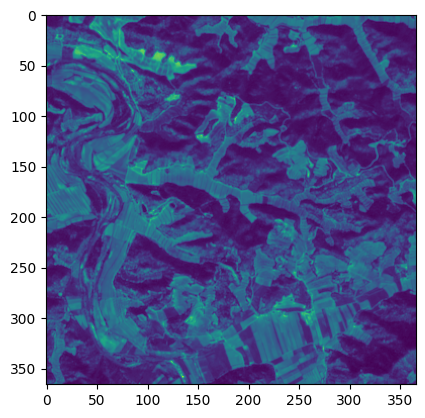

In [9]:
def get_monthly_band_data_for_patch(patch, band_name):
    band = xr.open_dataset(xr.backends.NetCDF4DataStore(patch[band_name]))[band_name]
    band_data = monthly_band_data(band, patch.patch_year).copy()
    band_data_npint = np.array(band_data,  dtype=np.int32)
    return band_data_npint

dat = get_monthly_band_data_for_patch(patch=patch0, band_name='B02')
print(type(dat))
print(dat.shape)
plt.imshow(dat[0])

## Get label data from a patch

return a numpy array

<class 'numpy.ndarray'>
(366, 366)


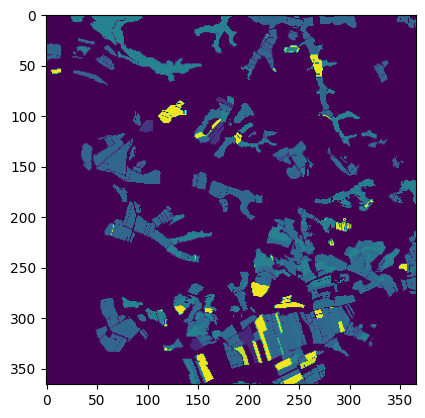

In [10]:
def get_label_data_for_patch(patch):
    #print(f'type(patch_data): {type(patch_data)}')
    label_data = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels']))
    label_data_np = np.array(label_data.to_dataarray())[0]
    return label_data_np

label_data0 = get_label_data_for_patch(patch0)
print(type(label_data0))
print(label_data0.shape)
_ = plt.imshow(label_data0)

## Get the 2d label mask from a patch given the label index

<class 'numpy.ndarray'>
(366, 366)


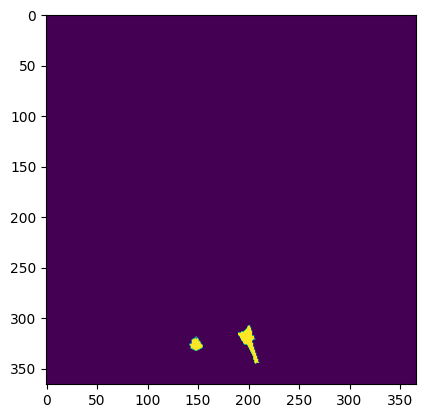

In [11]:
def get_label_mask_from_idx_for_patch(patch, label_idx=0):
    label_data = get_label_data_for_patch(patch)
    label_list = np.unique(label_data)[1:]
    label = get_label_id_from_idx_for_patch(label_list, label_idx)
    #print('label:', label, ', label_index:', label_idx)
    label_mask = np.zeros(label_data.shape, dtype=np.uint16)
    #print('label_mask.shape:', label_mask.shape, ', label:', label)
    #print('np.unique(label_mask):', np.unique(label_mask))
    label_mask[label_data == label] = 1
    #print('type(label_mask):', type(label_mask), ', label_mask.shape:', label_mask.shape)
    assert len(np.unique(label_mask)) > 1, "All pixels masked out"
    return label_mask

masked_band_data = get_label_mask_from_idx_for_patch(patch0, 0)
print(type(masked_band_data))
print(masked_band_data.shape)
plt.imshow(masked_band_data)

## Get the masked band data from a patch given the patch, band, and label

## Load a patch file directly into a DataFrame

In [12]:
def get_masked_band_from_label_for_patch(patch, band_name, label):
    label_idx = get_label_idx_from_id_for_patch(patch, label)
    #masked_band = np.array(patch_data[band_name]['monthly'].copy(), dtype=np.int32)
    masked_band = get_monthly_band_data_for_patch(patch=patch0, band_name=band_name)
    label_mask = get_label_mask_from_idx_for_patch(patch, label_idx)
    masked_band[:,label_mask == 0] = 0
    return masked_band

label1 = 330
band1 = 'B03'
label_idx1 = get_label_idx_from_id_for_patch(patch0, label1)
print(f'label_idx1:', label_idx1)
name1 = get_label_name_from_idx_for_patch(patch0, label_idx1)
df = pd.DataFrame({'band': ['B02', 'B03', 'B04', 'B08']})
df['label'] = label1
df['label_index'] = label_idx1
df['name'] = name1
df['masked_band'] = df.apply(lambda row: get_masked_band_from_label_for_patch(patch0, row.band, row.label), axis=1)
df

label_idx1: 2


band  label  label_index    name  \
0  B02    330            2  Grapes   
1  B03    330            2  Grapes   
2  B04    330            2  Grapes   
3  B08    330            2  Grapes   

                                         masked_band  
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
3  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...

In [13]:
def load_patch_file_to_df2(patch_file):
    patch = netCDF4.Dataset(Path(patch_file), 'r')
    print(f'patch file "{patch_file}" contains patch data from {patch.patch_name}')
    B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02
    B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03
    B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04
    B08 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08

    label_list = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels']))
    #label_array = np.array(patch_data['labels'].to_dataarray()[0])
    #unique_labels = np.sort(np.unique(label_array))[1:]
    unique_labels = get_unique_labels(label_list)
    print(f'unique_labels:', unique_labels)

    bands = ['B02', 'B03', 'B04', 'B08']
    index = pd.MultiIndex.from_product([unique_labels, bands], names = ["label", "band"])
    

    df = pd.DataFrame(index = index).reset_index()
    df['patch_name'] = patch.patch_full_name
    df['label_index'] = df.apply(lambda row: get_label_idx_from_id_for_patch(patch, row.label), axis=1)
    df['label_name'] = df.apply(lambda row: get_label_name_from_idx_for_patch(patch, row.label_index), axis=1)
    df['masked_band'] = df.apply(lambda row: get_masked_band_from_label_for_patch(patch, row.band, row.label), axis=1)
    
    #df['label_count'] = df.apply(lambda row: count_label_mask_pixels(patch_data, row.label_index), axis=1)
    return patch, df
    
files = sorted(glob('dataset/netcdf/*.nc'))
print(f'{len(files)} NetCDF4 files')
print(files[0:5])
patch, patch_df_test = load_patch_file_to_df2(files[5])
patch_df_test.head()

300 NetCDF4 files
['dataset/netcdf/2019_31TBF_patch_17_11.nc', 'dataset/netcdf/2019_31TBF_patch_17_12.nc', 'dataset/netcdf/2019_31TBF_patch_17_13.nc', 'dataset/netcdf/2019_31TBF_patch_18_11.nc', 'dataset/netcdf/2019_31TBF_patch_18_12.nc']
patch file "dataset/netcdf/2019_31TBF_patch_18_13.nc" contains patch data from patch_18_13
unique_labels: [110 150 330 353 361 442 911 975 998]


label band              patch_name  label_index label_name  \
0    110  B02  2019_31TBF_patch_18_13            0      Wheat   
1    110  B03  2019_31TBF_patch_18_13            0      Wheat   
2    110  B04  2019_31TBF_patch_18_13            0      Wheat   
3    110  B08  2019_31TBF_patch_18_13            0      Wheat   
4    150  B02  2019_31TBF_patch_18_13            1     Barley   

                                         masked_band  
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
3  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
4  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...

Index(['label', 'band', 'patch_name', 'label_index', 'label_name',
       'masked_band'],
      dtype='object')
(6, 366, 366)


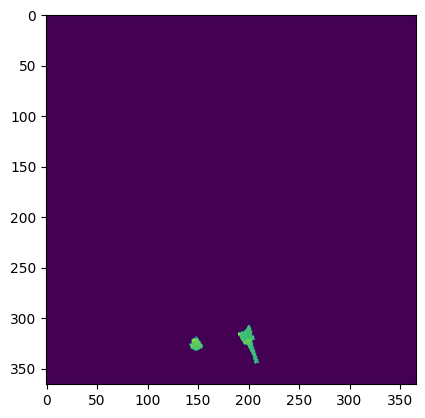

In [14]:
print(patch_df_test.columns)
print(patch_df_test['masked_band'][0].shape)
plt.imshow(patch_df_test['masked_band'][0][0])

## Functions for Label Access and Conversion

In [15]:
def get_label_list(patch_data):
    label_array = np.array(patch_data['labels'].to_dataarray()[0])
    label_list = np.sort(np.unique(label_array))[1:]
    return label_list

def get_label_idx_from_id(patch_data, label_id=0):
    labels = get_label_list(patch_data)
    label_idx = np.where(np.sort(labels) == label_id)[0][0]
    return label_idx

def get_label_id_from_idx(patch_data, label_index=0):
    labels = get_label_list(patch_data)
    #print(f'get_label_id_from_idx(patch_data, label_index={label_index}')
    label_id = np.sort(labels)[label_index]
    return label_id

def get_label_name_from_idx(patch_data, label_index=0):
    label_id = get_label_id_from_idx(patch_data, label_index)
    label_name = decode_label(label_id)
    return label_name

def get_label_data(patch_data):
    #print(f'type(patch_data): {type(patch_data)}')
    label_data = np.array(patch_data['labels'].to_dataarray())[0]
    return label_data

def get_label_mask_from_id(patch_data, label=0):
    label_data = get_label_data(patch_data)
    label_mask = np.zeros(label_data.shape, dtype=np.uint16)
    label_mask[label_data == label] = 1
    assert len(np.unique(label_mask)) > 1, "All pixels masked out"
    return label_mask

def get_label_mask_from_idx(patch_data, label_index=0):
    label_data = get_label_data(patch_data)
    label = get_label_id_from_idx(patch_data, label_index)
    #print('label:', label, ', label_index:', label_index)
    label_mask = np.zeros(label_data.shape, dtype=np.uint16)
    #print('label_mask.shape:', label_mask.shape, ', label:', label)
    #print('np.unique(label_mask):', np.unique(label_mask))
    label_mask[label_data == label] = 1
    #print('type(label_mask):', type(label_mask), ', label_mask.shape:', label_mask.shape)
    assert len(np.unique(label_mask)) > 1, "All pixels masked out"
    return label_mask

def count_label_mask_pixels(patch_data, label_idx):
    label_mask = get_label_mask_from_idx(patch_data, label_idx)
    unique, counts = np.unique(label_mask, return_counts=True)
    #print('mask pixels via np.unique:', counts)
    return counts[1]

unique_indexes = get_label_list(patch_data0)
print('get_label_list:', unique_indexes)

fields = decode_labels(unique_indexes)
print('decode_labels (Crops):', fields)

label_mask = get_label_mask_from_idx(patch_data0, 0)
type(label_mask), label_mask.shape

print(f'Patch has {count_label_mask_pixels(patch_data0, 0)} pixels of index 0')
print(f'Patch has {count_label_mask_pixels(patch_data0, 1)} pixels of index 1')

get_label_list: [110 150 330 353 361 442 911 975 998]
decode_labels (Crops): ['Wheat' 'Barley' 'Grapes' 'Cherries and sour cherries' 'Almonds' 'Olives'
 'Temporary grass crops' 'Fallow land' 'Unknown crops']
Patch has 385 pixels of index 0
Patch has 384 pixels of index 1


### A convenience function to get all monthly pixel intensity data from a specific band of a specific crop

This requires the entire patch object instead of only the name, as would be done in a multi-patch interface

In [16]:
def get_masked_band_from_label(patch_data, band_name, label):
    label_idx = get_label_idx_from_id(patch_data, label)
    masked_band = np.array(patch_data[band_name]['monthly'].copy(), dtype=np.int32)
    label_mask = get_label_mask_from_idx(patch_data, label_idx)
    masked_band[:,label_mask == 0] = 0
    return masked_band

label1 = 330
label_idx1 = get_label_idx_from_id(patch_data0, label1)
name1 = get_label_name_from_idx(patch_data0, label_idx1)
df = pd.DataFrame({'band': ['B02', 'B03', 'B04', 'B08']})
df['label'] = label1
df['label_index'] = label_idx1
df['name'] = name1
df['masked_band'] = df.apply(lambda row: get_masked_band_from_label(patch_data0, row.band, row.label), axis=1)
df

band  label  label_index    name  \
0  B02    330            2  Grapes   
1  B03    330            2  Grapes   
2  B04    330            2  Grapes   
3  B08    330            2  Grapes   

                                         masked_band  
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...  
3  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...

<class 'pandas.core.series.Series'>
(6, 366, 366)


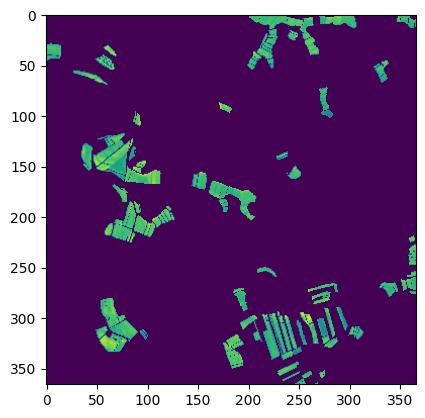

In [17]:
print(type(df['masked_band']))
print(df['masked_band'].values[0].shape)
plt.imshow(df['masked_band'].values[0][0])

## Load patch data dictionary into a DataFrame

In [18]:
def patch_data_to_df(patch_data):
    labels = get_label_list(patch_data)
    bands = ['B02', 'B03', 'B04', 'B08']
    index = pd.MultiIndex.from_product([labels, bands], names = ["label", "band"])
    df = pd.DataFrame(index = index).reset_index()
    df['patch_name'] = patch.patch_full_name
    df['label_index'] = df.apply(lambda row: get_label_idx_from_id(patch_data, row.label), axis=1)
    df['label_name'] = df.apply(lambda row: get_label_name_from_idx(patch_data, row.label_index), axis=1)
    df['masked_band'] = df.apply(lambda row: get_masked_band_from_label(patch_data, row.band, row.label), axis=1)
    df['label_count'] = df.apply(lambda row: count_label_mask_pixels(patch_data, row.label_index), axis=1)
    return df

patch6, patch_data6 = load_patch_file(files[5])
pdat6 = patch_data_to_df(patch_data6)
pdat6.head(10)

label band              patch_name  label_index label_name  \
0    110  B02  2019_31TBF_patch_18_13            0      Wheat   
1    110  B03  2019_31TBF_patch_18_13            0      Wheat   
2    110  B04  2019_31TBF_patch_18_13            0      Wheat   
3    110  B08  2019_31TBF_patch_18_13            0      Wheat   
4    150  B02  2019_31TBF_patch_18_13            1     Barley   
5    150  B03  2019_31TBF_patch_18_13            1     Barley   
6    150  B04  2019_31TBF_patch_18_13            1     Barley   
7    150  B08  2019_31TBF_patch_18_13            1     Barley   
8    330  B02  2019_31TBF_patch_18_13            2     Grapes   
9    330  B03  2019_31TBF_patch_18_13            2     Grapes   

                                         masked_band  label_count  
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          385  
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          385  
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          385  
3  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          385  
4  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          384  
5  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          384  
6  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          384  
7  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          384  
8  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...        11086  
9  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...        11086

Index(['label', 'band', 'patch_name', 'label_index', 'label_name',
       'masked_band', 'label_count'],
      dtype='object')
(6, 366, 366)


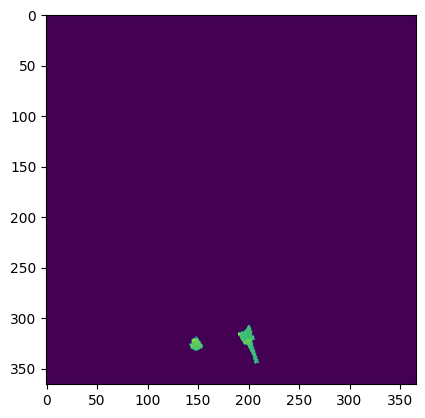

In [19]:
print(pdat6.columns)
print(pdat6['masked_band'][0].shape)
plt.imshow(pdat6['masked_band'][0][0])

In [20]:
def load_patch_file_to_df(patch_file):
    __patch, __patch_data = load_patch_file(patch_file)
    df = patch_data_to_df(__patch_data)
    return df

pdat7 = load_patch_file_to_df(files[5])
pdat7.head(10)

label band              patch_name  label_index label_name  \
0    110  B02  2019_31TBF_patch_18_13            0      Wheat   
1    110  B03  2019_31TBF_patch_18_13            0      Wheat   
2    110  B04  2019_31TBF_patch_18_13            0      Wheat   
3    110  B08  2019_31TBF_patch_18_13            0      Wheat   
4    150  B02  2019_31TBF_patch_18_13            1     Barley   
5    150  B03  2019_31TBF_patch_18_13            1     Barley   
6    150  B04  2019_31TBF_patch_18_13            1     Barley   
7    150  B08  2019_31TBF_patch_18_13            1     Barley   
8    330  B02  2019_31TBF_patch_18_13            2     Grapes   
9    330  B03  2019_31TBF_patch_18_13            2     Grapes   

                                         masked_band  label_count  
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          385  
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          385  
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          385  
3  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          385  
4  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          384  
5  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          384  
6  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          384  
7  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...          384  
8  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...        11086  
9  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...        11086

Index(['label', 'band', 'patch_name', 'label_index', 'label_name',
       'masked_band', 'label_count'],
      dtype='object')
(6, 366, 366)


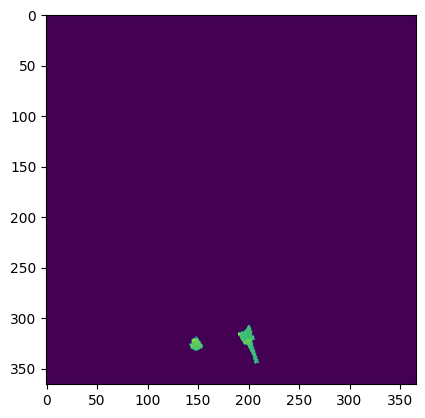

In [21]:
print(pdat7.columns)
print(pdat7['masked_band'][0].shape)
plt.imshow(pdat7['masked_band'][0][0])

## Show all images available for one band in one patch in one patch file

nimages: 27
ncols: 4 , nrows: 7
height: 21


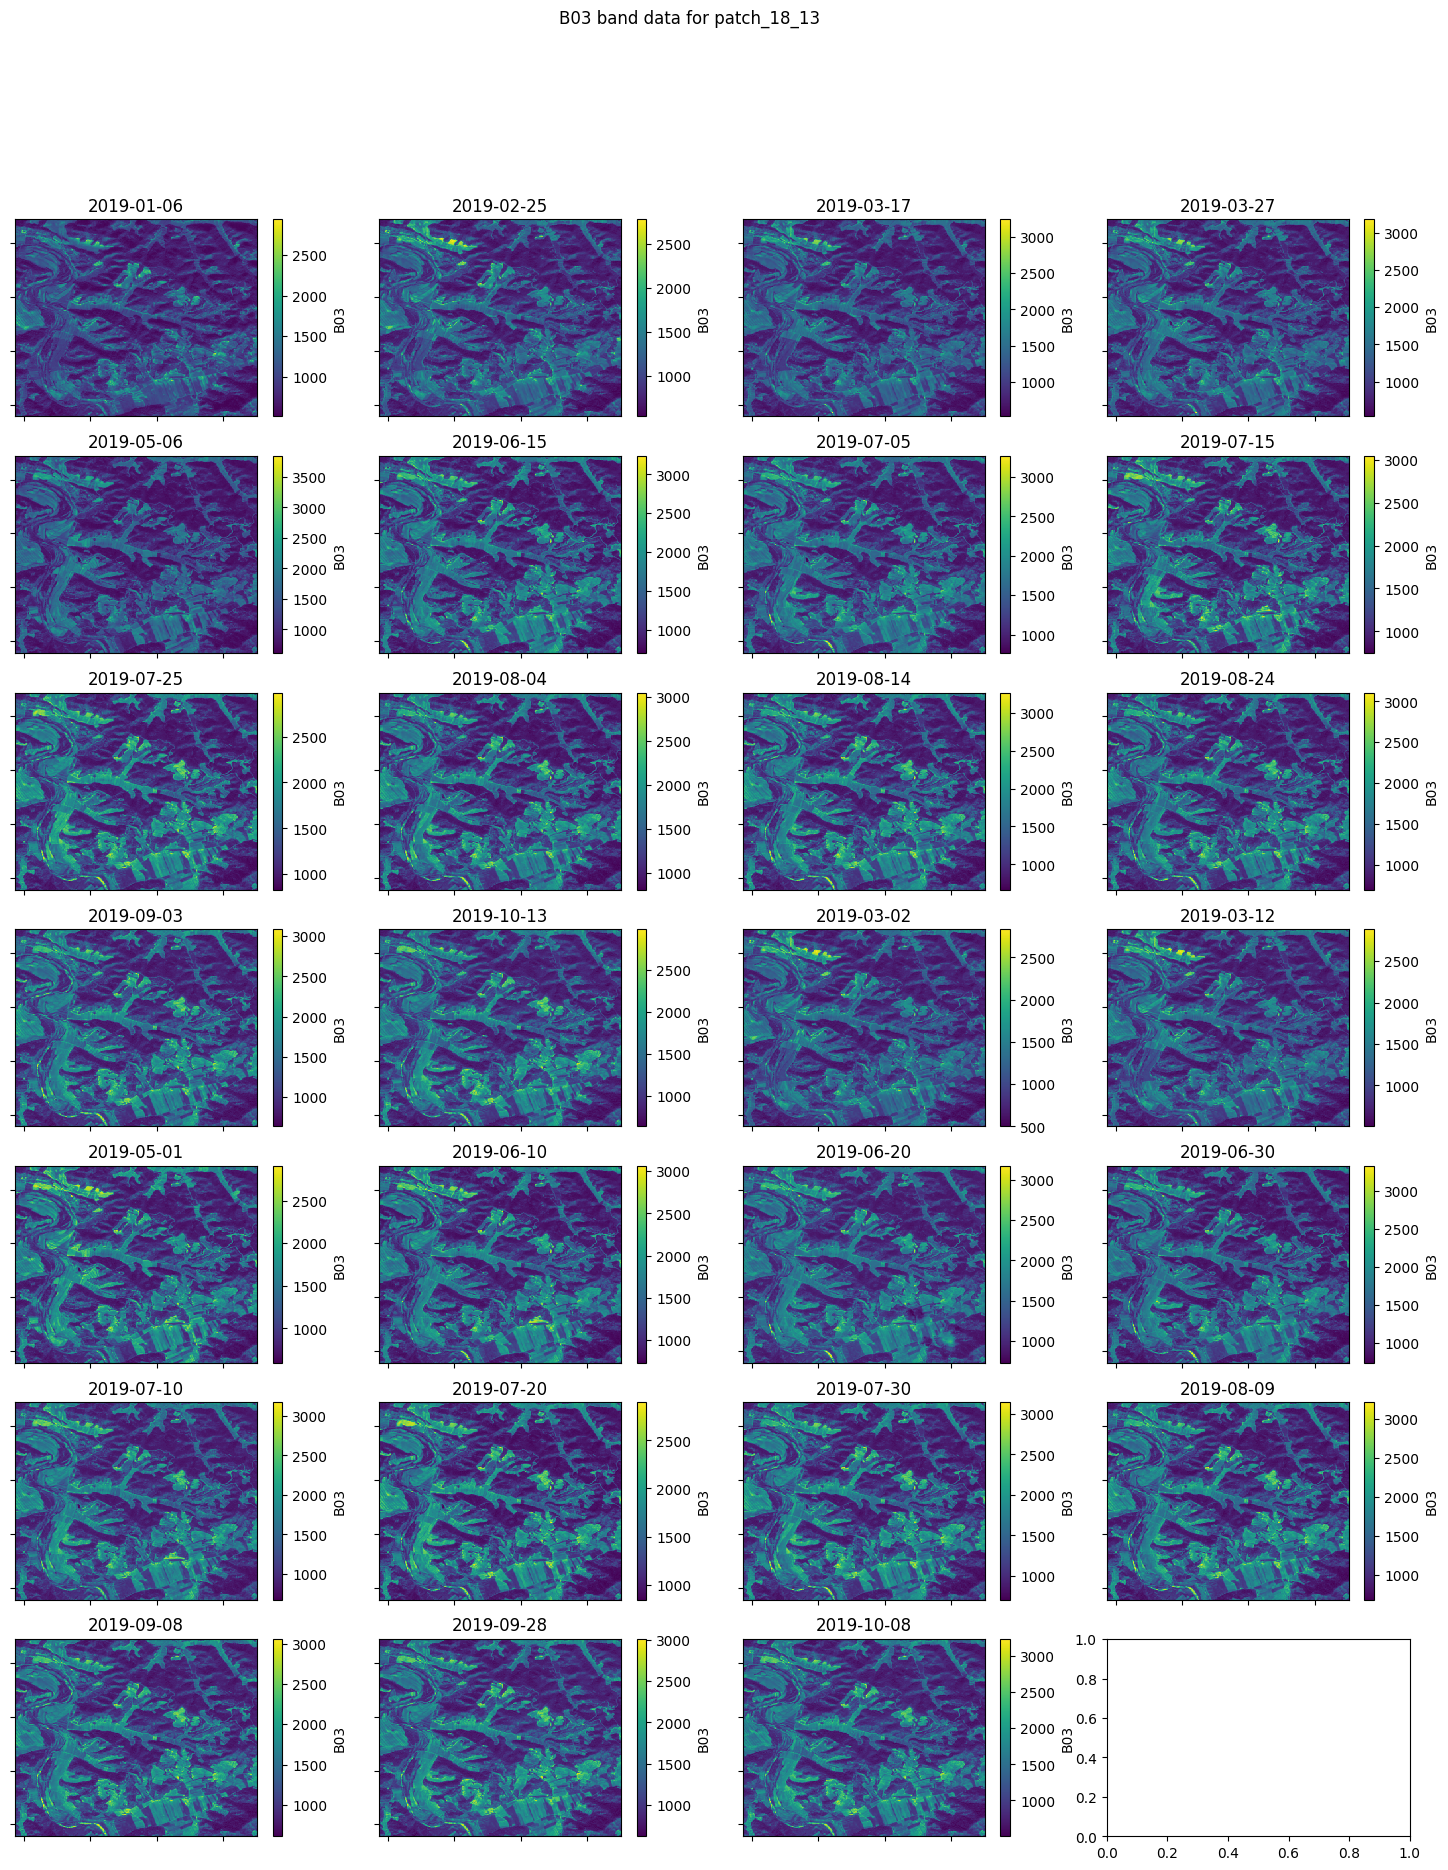

In [22]:
def show_patch_band(patch_data, band_name):
    nimages = len(patch_data[band_name]['band'].time)
    print(f'nimages:', nimages)
    ncols = 4
    nrows = (nimages + ncols - 1) // ncols
    print(f'ncols:', ncols, ', nrows:', nrows)
    height = nrows * 3
    print(f'height:', height)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, height))
    fig.suptitle(f'{band_name} band data for {patch_data["name"]}')
    
    for i, season in enumerate(patch_data[band_name]['band']):
        if i >= nimages: break
        ax = axes.flat[i]
        cax = patch_data[band_name]['band'].isel(time=i).plot(ax=ax)
    
    for i, ax in enumerate(axes.flat):
        if i >= nimages: break
        ax.axes.get_xaxis().set_ticklabels([])
        ax.axes.get_yaxis().set_ticklabels([])
        #ax.axes.axis('tight')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{patch_data[band_name]["band"].isel(time=i).time.dt.strftime("%Y-%m-%d").values}')
    
    plt.show()

show_patch_band(patch_data0, "B03")

## Plot monthly data from one band for the growing season

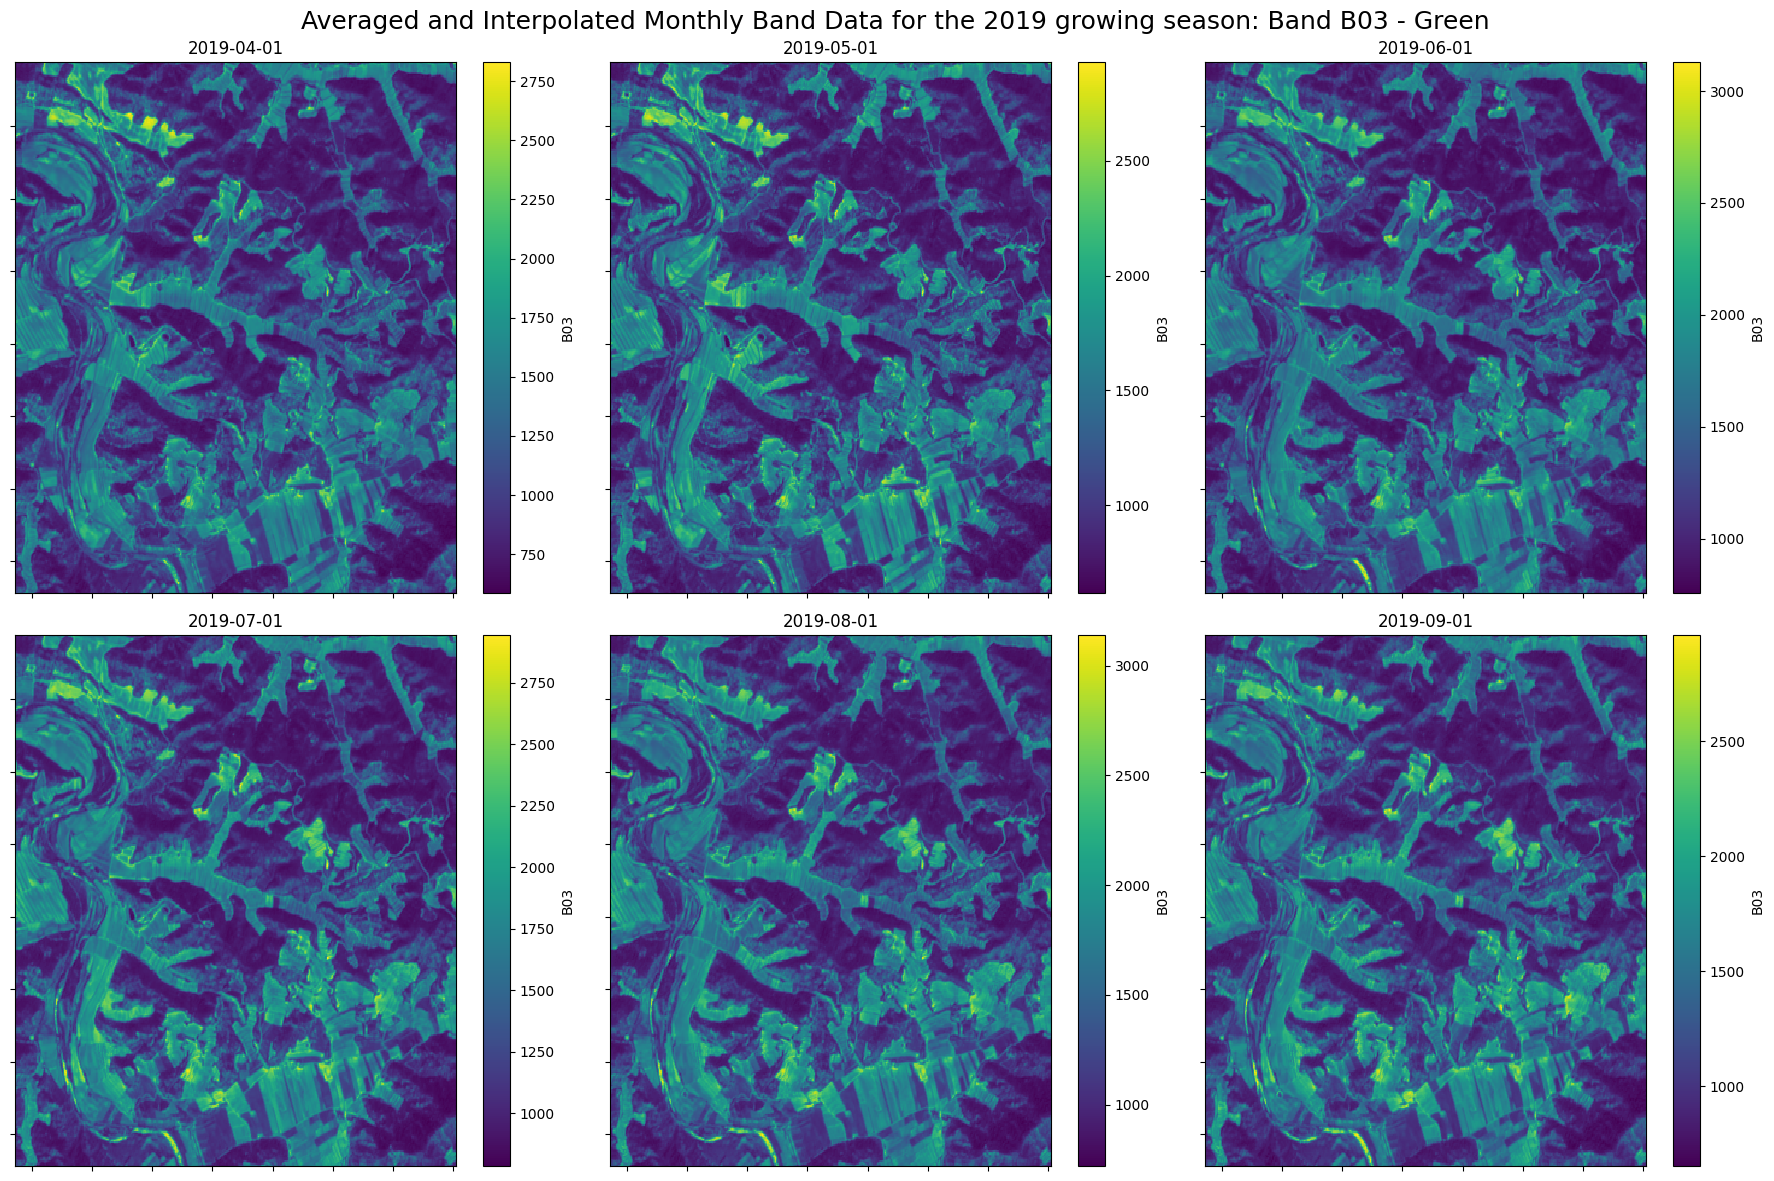

In [23]:
def show_monthly_band_data(patch_data, band_name):

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    fig.suptitle(
        f'Averaged and Interpolated Monthly Band Data for the {patch_data["year"]} growing season: Band {patch_data[band_name]["title"]}',
        fontsize=18
    )
        
    for i in range(len(patch_data[band_name]['monthly'])):
        ax = axes.flat[i]
        cax = patch_data[band_name]['monthly'].isel(time_bins=i).plot(ax=ax)
    
    for i, ax in enumerate(axes.flat):
        ax.axes.get_xaxis().set_ticklabels([])
        ax.axes.get_yaxis().set_ticklabels([])
        ax.axes.axis('tight')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(f'{patch_data[band_name]["monthly"].isel(time_bins=i).time_bins.dt.strftime("%Y-%m-%d").values}')
    
    plt.tight_layout()
    plt.show()

show_monthly_band_data(patch_data0, "B03")

## Display band data, labels, and parcels

10 unique label indexes: [  0 110 150 330 353 361 442 911 975 998]
555 unique parcel ids: [      0 1097569 1097577 1097641 1097647 1097650 1097651 1097654 1097696
 1097700 1097702 1097720 1097738 1097739 1098183 1098188 1098197 1098218
 1098222 1098245 1098246 1098251 1098252 1098256 1098262 1098278 1098280
 1098286 1098287 1098295 1098302 1098303 1098305 1098307 1098311 1098314
 1098344 1098347 1098395 1098402 1098405 1098438 1098441 1098442 1098444
 1098450 1098455 1098456 1098462 1098471 1098474 1098513 1098522 1100408
 1100410 1100411 1100412 1100414 1100808 1100809 1100810 1100811 1100981
 1100985 1100986 1100992 1100994 1100995 1100999 1101000 1101001 1101003
 1101019 1101075 1101086 1101088 1101096 1101110 1101121 1101127 1101129
 1101785 1101789 1101795 1101801 1101802 1101805 1101811 1101816 1101819
 1101822 1101827 1101830 1101834 1101836 1101837 1101841 1101843 1101848
 1101854 1101866 1101867 1101871 1101875 1101879 1101881 1101894 1101902
 1101905 1101910 1101915 1101927 1

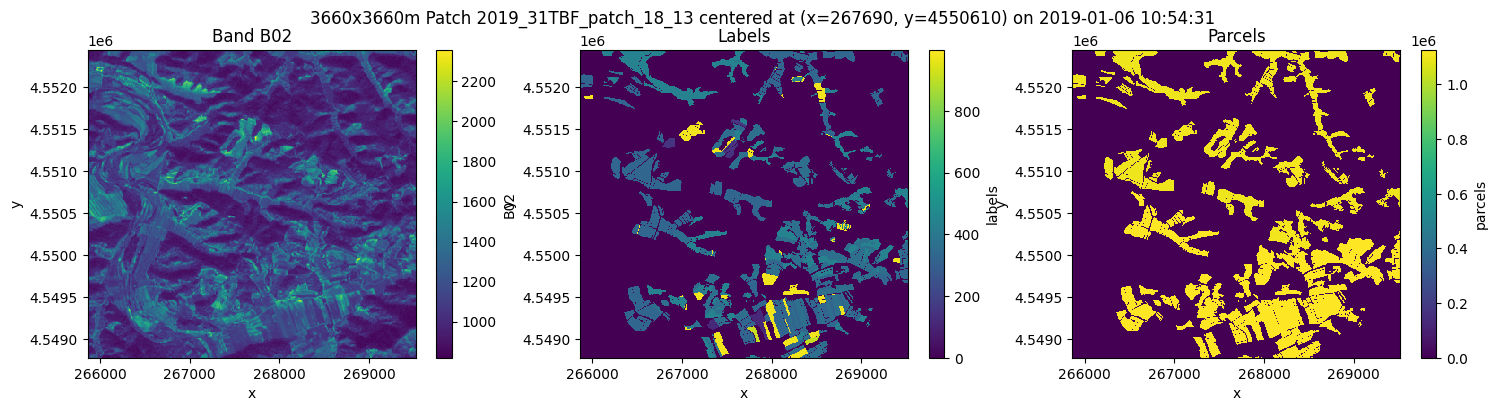

In [24]:
def show_patch(patch_data, time=0):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    # Extract location information -- only available in the parcel group
    x = (np.array(patch_data['parcels'].coords['x'])[-1] + np.array(patch_data['parcels'].coords['x'])[0]) / 2
    y = (np.array(patch_data['parcels'].coords['y'])[-1] + np.array(patch_data['parcels'].coords['y'])[0]) / 2
    band_data = patch_data['B02']['band']

    # Extract time information
    ftime = band_data.isel(time=time).time.dt.strftime("%Y-%m-%d %H:%M:%S").values
    fig.suptitle(f'3660x3660m Patch {patch.patch_full_name} centered at (x={x:.0f}, y={y:.0f}) on {ftime}')
    
    band_data.isel(time=time).plot(ax=ax[0])
    ax[0].set_title(f'Band B02')

    labels = np.unique(patch_data['labels'].to_dataarray())
    print(f'{len(labels)} unique label indexes:', labels)
    patch_data['labels'].labels.plot(ax=ax[1])
    ax[1].set_title('Labels')

    parcels = np.unique(patch_data['parcels'].parcels)
    print(f'{len(parcels)} unique parcel ids:', parcels)
    patch_data["parcels"].parcels.plot(ax=ax[2])
    ax[2].set_title(f'Parcels')

show_patch(patch_data0)

### Define directions

Arbitrarily decide that the positive directions are east and south, due to the increasing directions in our dataset

_look for negative numbers as an indication of an error in calculations_

In [25]:
def west(patch_data):
    return np.sort(np.array(patch_data['parcels'].coords['x']))[0]

def east(patch_data):
    return np.sort(np.array(patch_data['parcels'].coords['x']))[-1]

def north(patch_data):
    return np.sort(np.array(patch_data['parcels'].coords['y']))[0]

def south(patch_data):
    return np.sort(np.array(patch_data['parcels'].coords['y']))[-1]

def rangex(patch_data):
    return east(patch_data) - west(patch_data)
    
def rangey(patch_data):
    return south(patch_data) - north(patch_data)

print('west:', west(patch_data0))
print('east:', east(patch_data0))
print('north:', north(patch_data0))
print('south:', south(patch_data0))

west: 265865.0
east: 269515.0
north: 4548785.0
south: 4552435.0


## Function to format Ticks on Plot Axes

* Pixels have 10m resolution, so update ticks to show 10m per pixel

In [26]:
def plot_tick_format(tick_val, tick_pos):
    return int(tick_val * 10)

## Highlight Label Bounding Boxes

* Read a mask image (such as a crop label)
* Draw an outline around labeled pixels
* Allow width specification
* Clear the original label

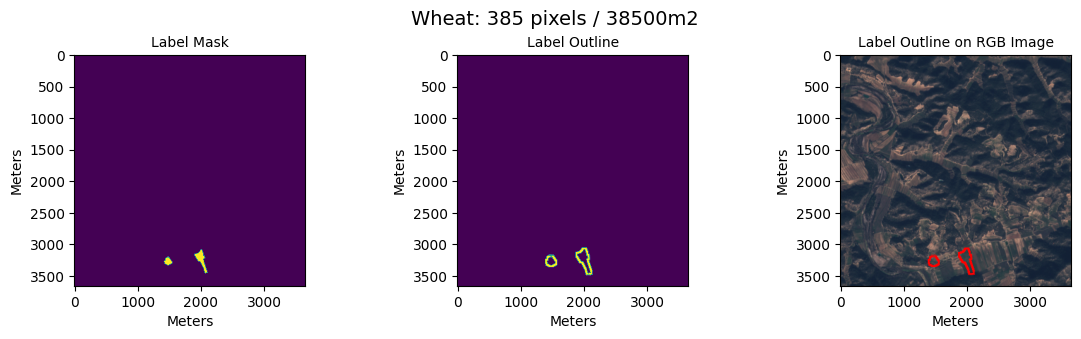

In [27]:
def draw_label_outline(image, color=1, width=3):
    #print('type(image):', type(image))
    outline_image = image.copy()
    
    # TODO: determine how to do this without a loop; maybe consider generic_filter
    for w in range(width):
        indicies = np.where((outline_image > 0))
        ai = np.array(indicies) + 1
        for addsub in [-1, 1]:
            for idx in range(2):
                for n in range(2):
                    ai=np.clip(ai, 0, 365)
                    outline_image[tuple(ai)] = color
                    ai[idx] = np.array(indicies)[idx] + addsub
    
    # Remove center
    outline_image[image > 0] = 0
    return outline_image

def show_label_outline(patch_data, label_idx=0):
    label = get_label_id_from_idx(patch_data, label_idx)
    label_img = get_label_mask_from_idx(patch_data, label_idx)
    outline = draw_label_outline(label_img)
    rgb_outline = patch_data['rgbt0'].copy()
    rgb_outline[outline != 0] = [0xFF,0,0]
    num_pix = count_label_mask_pixels(patch_data, label_idx)
    m2 = num_pix * 100
    
    fig, ax = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(f'{decode_label(label)}: {num_pix} pixels / {m2}m2', y=1.03, fontsize=14)
    ax[0].imshow(label_img)
    ax[0].set_title(f'Label Mask', fontsize=10)
    ax[0].xaxis.set_major_formatter(plot_tick_format)
    ax[0].yaxis.set_major_formatter(plot_tick_format)
    ax[0].set_xlabel('Meters')
    ax[0].set_ylabel('Meters')
    #ax[0].set_xticklabels([0, 1880, 3660])
    ax[1].imshow(outline)
    ax[1].set_title(f'Label Outline', fontsize=10)
    ax[2].imshow(rgb_outline)
    ax[2].set_title(f'Label Outline on RGB Image', fontsize=10)
    
    for n in range(3):
        ax[n].xaxis.set_major_formatter(plot_tick_format)
        ax[n].yaxis.set_major_formatter(plot_tick_format)
        ax[n].set_xlabel('Meters')
        ax[n].set_ylabel('Meters')

show_label_outline(patch_data0, label_idx=0)

## Zoom to the masked RGB Crop data

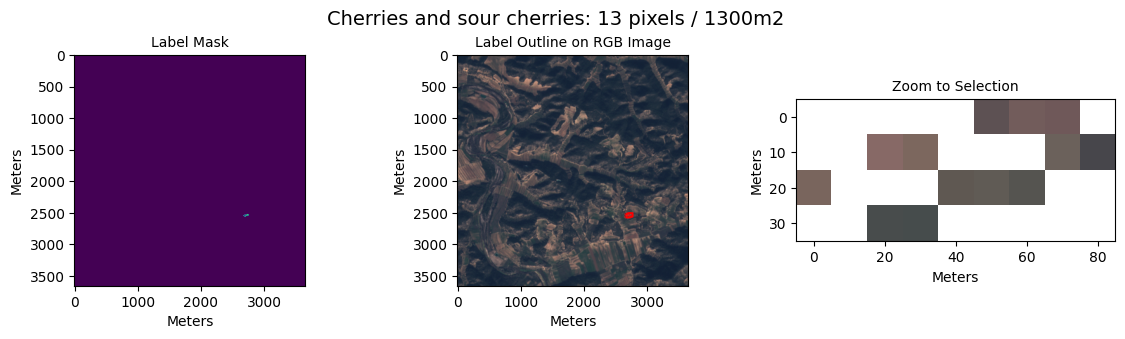

In [28]:
def auto_zoom(image):
    '''
    Zoom to the smallest image containing all non-white pixels

    If any non-white pixels exists on all 4 outer 
    '''
    indicies = np.array(np.where(np.all(image != (0xFF, 0xFF, 0xFF), axis=-1)))
    assert indicies.shape[1] > 0, "No non-white pixels were found in RGB image"
    top = np.min(indicies[0])
    bottom = np.min([365, np.max(indicies[0]) + 1])
    left = np.min(indicies[1])
    right = np.min([365, np.max(indicies[1]) + 1])
    #print('left:', left, ', right:', right, ', top:', top, ', bottom', bottom)
    return image[top:bottom, left:right, :]

def get_rgb_selection(patch_data, label_index=0):
    label_mask = get_label_mask_from_idx(patch_data, label_index)
    assert len(np.unique(label_mask)) > 1, "All pixels masked out"
    rgb3_selection = patch_data['rgbt0'].copy()
    rgb3_selection[label_mask == 0] = [0xFF,0xFF,0xFF]
    return rgb3_selection

# Note: this is obsolete, but may be used again later
def zoom_to_label(patch_data, label_index=0):
    rgb3_selection = get_rgb_selection(patch_data, label_index)
    return auto_zoom(rgb3_selection)

def show_zoom_to_label(patch_data, label_idx=3):

    label = get_label_id_from_idx(patch_data, label_idx)
    #print(f'label={label}')
    
    label_mask = get_label_mask_from_idx(patch_data, label_idx)
    #print(label_mask.shape)
    
    outline = draw_label_outline(label_mask)
    rgb_outline = patch_data['rgbt0'].copy()
    rgb_outline[outline != 0] = [0xFF,0,0]
    rgb3_selection = get_rgb_selection(patch_data, label_idx)
    rgb_crop_zoom = auto_zoom(rgb3_selection)
    
    num_pix = count_label_mask_pixels(patch_data, label_idx)
    m2 = num_pix * 100
    
    fig, ax = plt.subplots(ncols=3, figsize=(14, 3))
    fig.suptitle(f'{decode_labels([label])[0]}: {num_pix} pixels / {m2}m2', y=1.03, fontsize=14)
    ax[0].imshow(label_mask)
    ax[0].set_title(f'Label Mask', fontsize=10)
    ax[0].xaxis.set_major_formatter(plot_tick_format)
    ax[0].yaxis.set_major_formatter(plot_tick_format)
    ax[0].set_xlabel('Meters')
    ax[0].set_ylabel('Meters')
    ax[1].imshow(rgb_outline)
    ax[1].set_title(f'Label Outline on RGB Image', fontsize=10)
    ax[2].imshow(rgb_crop_zoom)
    ax[2].set_title(f'Zoom to Selection', fontsize=10)
    
    for n in range(3):
        ax[n].xaxis.set_major_formatter(plot_tick_format)
        ax[n].yaxis.set_major_formatter(plot_tick_format)
        ax[n].set_xlabel('Meters')
        ax[n].set_ylabel('Meters')

show_zoom_to_label(patch_data0, label_idx=3)

## A function to show plots of all labels in a patch

In [ ]:
def show_labels_in_patch(patch_data):

    labels = get_label_list(patch_data)
    for n,label in enumerate(labels):
        label_mask = get_label_mask_from_id(patch_data, label)
        outline = draw_label_outline(label_mask)
        rgb3_outline = patch_data['rgbt0'].copy()
        rgb3_outline[outline != 0] = [0xFF,0,0]
    
        rgb3_selection = patch_data['rgbt0'].copy()
        rgb3_selection[label_mask == 0] = [0xFF,0xFF,0xFF]
        rgb3_crop_zoom = auto_zoom(rgb3_selection)
    
        num_pix = count_label_mask_pixels(patch_data, n)
        m2 = num_pix * 100
        
        fig, ax = plt.subplots(ncols=3, figsize=(14, 3))
        fig.suptitle(f'{decode_labels([label])[0]}: {num_pix} pixels / {m2}m2')
        ax[0].imshow(rgb3_outline)
        ax[1].imshow(rgb3_selection)
        ax[2].imshow(rgb3_crop_zoom)
    
        for n in range(3):
            ax[n].xaxis.set_major_formatter(plot_tick_format)
            ax[n].yaxis.set_major_formatter(plot_tick_format)
            ax[n].set_xlabel('Meters')
            ax[n].set_ylabel('Meters')
            #ax[n].set_ylim([0, :])

show_labels_in_patch(patch_data0)

## A function to draw all 4 band histograms of an entire patch

In [ ]:
def draw_patch_histogram(patch_data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
    fig.suptitle(f'Histogram of Patch {patch_data["name"]}')
    ax0 = axes[0].hist([
            np.array(patch_data['B04']['band'].isel(time=0)).flatten(),
            np.array(patch_data['B02']['band'].isel(time=0)).flatten(),
            np.array(patch_data['B03']['band'].isel(time=0)).flatten(),
            np.array(patch_data['B08']['band'].isel(time=0)).flatten()
    ], bins=256)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    _ = axes[0].set_title(f'B02, B03, B04, and B08 at time=0')
    ax1 = axes[1].hist([
            patch_data['B04']['uint8'].flatten(),
            patch_data['B02']['uint8'].flatten(),
            patch_data['B03']['uint8'].flatten(),
            patch_data['B08']['uint8'].flatten()
    ], bins=256)
    _ = axes[1].set_title(f'B02, B03, B04, and B08 averaged over all {patch_data["B04"]["uint8"].shape[0]} time periods')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    plt.show()

draw_patch_histogram(patch_data0)

## Draw the set of band histograms for a specific label

In [ ]:
def plot_masked_hist_2(ax, band, mask, pixel_height=6):
    max = np.max(band)
    cmap = plt.colormaps['jet']
    nbins = 256
    __band = band.copy()
    hist = np.zeros((band.shape[0]*pixel_height, nbins))
    for n in range(band.shape[0]):
        __band_data = np.array(__band[n,:,:])
        __band_data[mask == 0] = 0
        hist[n*pixel_height:n*pixel_height+pixel_height], _ = np.histogram(__band_data, bins=nbins)
        hist[n*pixel_height:n*pixel_height+pixel_height,0] = 0
    #print(f'hist_max: {np.max(hist)}, shape: {hist.shape}, dtype: {hist.dtype}')
    _ = ax.imshow(hist)
    _ = ax.set_xticks([])

def show_hist(patch_data, band_name):
    fig, ax = plt.subplots(figsize=(18, 4))
    #fig.suptitle(f'Histogram of Patch {patch_data["name"]}')
    
    _ = plot_masked_hist_2(ax, patch_data[band_name]['monthly'], label_mask)
    _ = ax.set_title(f'{patch_data["name"]}: Montly Histograms for band {patch_data[band_name]["title"]}')
    _ = ax.set_ylabel('month')
    _ = ax.set_yticks([])

show_hist(patch_data0, "B03")

In [ ]:
def plot_crop(patch_data, label_idx=0):
    name = get_label_name_from_idx(patch_data, label_idx)
    #print(f'Plotting "{name}" from {patch_data["name"]}')
    label_img = get_label_mask_from_idx(patch_data, label_idx)
    outline = draw_label_outline(label_img)
    rgb3_outline = patch_data['rgbt0'].copy()
    rgb3_outline[outline != 0] = [0xFF,0,0]
    
    label_mask = get_label_mask_from_idx(patch_data, label_idx)
    rgb3_selection = patch_data['rgbt0'].copy()
    rgb3_selection[label_mask == 0] = [0xFF,0xFF,0xFF]
    
    rgb3_crop_zoom = auto_zoom(rgb3_selection)

    num_pix = count_label_mask_pixels(patch_data, label_idx)
    m2 = num_pix * 100
    
    fig = plt.figure(figsize=(16, 4))
    fig.suptitle(f'{patch_data["name"]} ({patch_data["patch_country_code"]}): {name} in {patch_data["year"]}: {num_pix} pixels / {m2}m2')
    gs = gridspec.GridSpec(4,3)
    
    ax0 = fig.add_subplot(gs[:,0])
    ax0.imshow(rgb3_outline)
    ax0.set_title('Label Outline')
    
    ax1 = fig.add_subplot(gs[:,1])
    ax1.imshow(rgb3_crop_zoom)
    ax1.set_title('Masked and Zoomed')
    
    ax20 = fig.add_subplot(gs[0,2])
    _ = plot_masked_hist_2(ax20, patch_data['B02']['monthly'], label_mask)
    _ = ax20.set_title(f'Histogram of {patch_data["B02"]["title"]}')
    _ = ax20.set_ylabel('month')
    _ = ax20.set_yticks([])
    
    ax21 = fig.add_subplot(gs[1,2])
    _ = plot_masked_hist_2(ax21, patch_data['B03']['monthly'], label_mask)
    _ = ax21.set_title(f'Histogram of {patch_data["B03"]["title"]}')
    _ = ax21.set_ylabel('month')
    _ = ax21.set_yticks([])
    
    ax22 = fig.add_subplot(gs[2,2])
    _ = plot_masked_hist_2(ax22, patch_data['B04']['monthly'], label_mask)
    _ = ax22.set_title(f'Histogram of {patch_data["B04"]["title"]}')
    _ = ax22.set_ylabel('month')
    _ = ax22.set_yticks([])
    
    ax23 = fig.add_subplot(gs[3,2])
    _ = plot_masked_hist_2(ax23, patch_data['B08']['monthly'], label_mask)
    _ = ax23.set_title(f'Histogram of {patch_data["B08"]["title"]}')
    _ = ax23.set_ylabel('month')
    _ = ax23.set_yticks([])

    #print(type(fig))
    #for n in range(3):
    #    ax[n].xaxis.set_major_formatter(plot_tick_format)
    #    ax[n].yaxis.set_major_formatter(plot_tick_format)
    #    ax[n].set_xlabel('Meters')
    #    ax[n].set_ylabel('Meters')
    #    #ax[n].set_ylim([0, :])    

plot_crop(patch_data0, 0)

## Plot all crops in a patch

In [ ]:
def plot_crops(patch_data):
    labels = get_label_list(patch_data)
    for n,label in enumerate(labels):
        #print(f'Plotting patch data for label {n}: {label}')
        plot_crop(patch_data, n)

plot_crops(patch_data0)

## Plot all crops in a patch file

In [ ]:
def plot_crops_in_file(patch_file):
    patch, patch_data = load_patch_file(patch_file)
    #patch
    labels = get_label_list(patch_data)
    for n,label in enumerate(labels):
        plot_crop(patch_data, n)
plot_crops_in_file(files[4])

## Find the same crop in 2 different patches

In [ ]:
def labels_in_both_patch_files(patch_files):
    unique_labels = []
    for n in range(2):
        #print(f'load file {n}: {patch_files[n]}')
        patch = netCDF4.Dataset(Path(patch_files[n]), 'r')
        labels = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels']))
        unique_labels.append(np.unique(labels.to_dataarray())[1:])
        print(f'file {n}: {files[n]}: unique_labels:', unique_labels[-1])
    
    label_intersections = unique_labels[0][np.in1d(unique_labels[0], unique_labels[1])]
    return label_intersections

label_intersections1 = labels_in_both_patch_files(files[0:2])
print(f'labels in both files:', label_intersections1)

### Compare histograms from the same crop in 2 different patch files

In [ ]:
def plot_crop_from_patch_file(patch_file, crop_label):
    print('patch_file:', patch_file)
    patch, patch_data = load_patch_file(patch_file)
    print(f'patch_data from {patch_data["name"]}')
    crop_idx = get_label_idx_from_id(patch_data, crop_label)
    plot_crop(patch_data, crop_idx)

plot_crop_from_patch_file(files[0], label_intersections1[0])
plot_crop_from_patch_file(files[1], label_intersections1[0])

### Compare histograms from another crop that exists in both patch files

In [ ]:
def plot_crop_from_patch_file(patch_file, crop_label):
    print('patch_file:', patch_file)
    patch, patch_data = load_patch_file(patch_file)
    print(f'patch_data from {patch_data["name"]}')
    crop_idx = get_label_idx_from_id(patch_data, crop_label)
    plot_crop(patch_data, crop_idx)

plot_crop_from_patch_file(files[0], label_intersections1[1])
plot_crop_from_patch_file(files[1], label_intersections1[1])

## Combine the same crop data from 2 different patchsets

In [ ]:
patch1, patch_data1 = load_patch_file(files[0])
patch2, patch_data2 = load_patch_file(files[1])

## A function to plot the histogram of the masked image

In [ ]:
def plot_tick_format_hist(tick_val, tick_pos):
    print('plot_tick_format_hist')
    return int(tick_val * 10)

def plot_masked_band_hist(ax, masked_band, pixel_height=6, ylabels='all'):
    xmin = 0
    xmax = np.max(masked_band)
    print(f'plot_masked_band_hist: shape={masked_band.shape}, type={masked_band.dtype}, band_max: {xmax}')
    cmap = plt.colormaps['jet']
    
    nbins = 256
    hist = np.zeros((masked_band.shape[0]*pixel_height, nbins))
    for n in range(masked_band.shape[0]):
        __band_data = np.array(masked_band[n,:,:])
        hist[n*pixel_height:n*pixel_height+pixel_height], _ = np.histogram(__band_data, bins=nbins)
        hist[n*pixel_height:n*pixel_height+pixel_height,0] = 0
    #print('hist_height:', n*pixel_height+pixel_height)
    ymin = pixel_height / 2
    ymax = n * pixel_height + pixel_height - pixel_height / 2
    _ = ax.imshow(hist)
    if ylabels == 'firstlast':
        _ = ax.yaxis.set_major_locator(ticker.FixedLocator([ymin, ymax]))
        _ = ax.set_yticklabels(['Apr', 'Sept'])
        _ = ax.set_xlabel('Sensor Amplitude (8-bit)', labelpad=-10)
    if ylabels == 'all':
        _ = ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(masked_band.shape[0]) * pixel_height + pixel_height / 2))
        _ = ax.set_yticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

    else:
        _ = ax.set_yticks([])
        #_ = ax.set_ylabel('Sensor Amplitude (8-bit)')

    _ = ax.set_xlabel(f'Sensor Amplitude (max={xmax})', labelpad=-2)
    _ = ax.xaxis.set_major_locator(ticker.FixedLocator([0, nbins-1]))
    _ = ax.set_xticklabels(['0', xmax])

fig, ax = plt.subplots(figsize=(18, 4))

patch1_B03_label330 = np.array(patch_data1['B03']['monthly'].copy())
label_mask = get_label_mask_from_idx(patch_data1, 0)
patch1_B03_label330[:,label_mask == 0] = 0

_ = plot_masked_band_hist(ax, patch1_B03_label330)
_ = ax.set_title(f'Monthly Histograms for band patch1_B03_label330')

### Try 2 different methods of counting pixels matching a value and compare to the default

All values should match

In [ ]:
def count_label_mask_pixels1(patch_data, label_idx):
    label_mask = get_label_mask_from_idx(patch_data1, label_idx)
    num_mask_pixel = label_mask[label_mask != 0].size
    return num_mask_pixel

def count_label_mask_pixels2(patch_data, label_idx):
    label_mask = get_label_mask_from_idx(patch_data1, label_idx)
    unique, counts = np.unique(label_mask, return_counts=True)
    return counts[1]

print(count_label_mask_pixels(patch_data1, 1))
print(count_label_mask_pixels1(patch_data1, 1))
print(count_label_mask_pixels2(patch_data1, 1))

## Assemble a Pandas dataframe with relevant crop data

This should eventually be done using the NetCDF4 patch, rather the the already-imported and converted one, which is in the current version of this notebook as of 12 April 2024.

In [ ]:
def patch_data_to_df(patch_data):
    labels = get_label_list(patch_data)
    bands = ['B02', 'B03', 'B04', 'B08']
    index = pd.MultiIndex.from_product([labels, bands], names = ["label", "band"])
    df = pd.DataFrame(index = index).reset_index()
    df['patch_name'] = patch_data['name']
    df['label_index'] = df.apply(lambda row: get_label_idx_from_id(patch_data, row.label), axis=1)
    df['label_name'] = df.apply(lambda row: get_label_name_from_idx(patch_data, row.label_index), axis=1)
    df['masked_band'] = df.apply(lambda row: get_masked_band_from_label(patch_data, row.band, row.label), axis=1)
    
    df['label_count'] = df.apply(lambda row: count_label_mask_pixels(patch_data, row.label_index), axis=1)
    return df

patch_df1 = patch_data_to_df(patch_data1)
patch_df1.head(10)

### Verify the conversion from a patch data dictionary to a dataframe

In [ ]:
print(patch_df1.columns)
print(patch_df1['masked_band'][0].shape)
plt.imshow(patch_df1['masked_band'][0][0])

### Convert the second patch dataset to a DataFrame

In [ ]:
patch_df2 = patch_data_to_df(patch_data2)
patch_df2.head(10)

### Verify the second data frame

In [ ]:
print(patch_df2.columns)
print(patch_df2['masked_band'][0].shape)
plt.imshow(patch_df2['masked_band'][0][0])

# Redundant functions -- maybe these can be removed

In [ ]:
def __get_label_list_for_patch(patch):
    label_array = np.array(patch_data['labels'].to_dataarray()[0])
    label_list = np.sort(np.unique(label_array))[1:]
    return label_list

def __get_label_idx_from_id(patch_data, label_id=0):
    labels = get_label_list(patch_data)
    label_idx = np.where(np.sort(labels) == label_id)[0][0]
    return label_idx

def __get_label_id_from_idx(patch_data, label_index=0):
    labels = get_label_list(patch_data)
    #print(f'get_label_id_from_idx(patch_data, label_index={label_index}')
    label_id = np.sort(labels)[label_index]
    return label_id

def __get_label_name_from_idx(patch_data, label_index=0):
    label_id = get_label_id_from_idx(patch_data, label_index)
    label_name = decode_label(label_id)
    return label_name

def __get_label_data(patch_data):
    #print(f'type(patch_data): {type(patch_data)}')
    label_data = np.array(patch_data['labels'].to_dataarray())[0]
    return label_data

def __get_label_mask_from_id(patch_data, label=0):
    label_data = get_label_data(patch_data)
    label_mask = np.zeros(label_data.shape, dtype=np.uint16)
    label_mask[label_data == label] = 1
    assert len(np.unique(label_mask)) > 1, "All pixels masked out"
    return label_mask

def __get_label_mask_from_idx(patch_data, label_index=0):
    label_data = get_label_data(patch_data)
    label = get_label_id_from_idx(patch_data, label_index)
    #print('label:', label, ', label_index:', label_index)
    label_mask = np.zeros(label_data.shape, dtype=np.uint16)
    #print('label_mask.shape:', label_mask.shape, ', label:', label)
    #print('np.unique(label_mask):', np.unique(label_mask))
    label_mask[label_data == label] = 1
    #print('type(label_mask):', type(label_mask), ', label_mask.shape:', label_mask.shape)
    assert len(np.unique(label_mask)) > 1, "All pixels masked out"
    return label_mask

def __count_label_mask_pixels(patch_data, label_idx):
    label_mask = get_label_mask_from_idx(patch_data, label_idx)
    unique, counts = np.unique(label_mask, return_counts=True)
    #print('mask pixels via np.unique:', counts)
    return counts[1]

unique_indexes = get_label_list(patch_data1)
print('get_label_list:', unique_indexes)

fields = decode_labels(unique_indexes)
print('decode_labels (Crops):', fields)

label_mask = __get_label_mask_from_idx(patch_data1, 0)
type(label_mask), label_mask.shape

print(f'Patch has {__count_label_mask_pixels(patch_data1, 0)} pixels of index 0')
print(f'Patch has {__count_label_mask_pixels(patch_data1, 1)} pixels of index 1')

# A function to convert the patch dict to a DataFrame -- May be obsolete

In [ ]:
def __patch_to_df(patch, patch_data):
    labels = get_label_list(patch_data)
    bands = ['B02', 'B03', 'B04', 'B08']
    index = pd.MultiIndex.from_product([labels, bands], names = ["label", "band"])
    df = pd.DataFrame(index = index).reset_index()
    df['patch_name'] = patch.patch_full_name
    df['label_index'] = df.apply(lambda row: get_label_idx_from_id(patch_data, row.label), axis=1)
    df['label_name'] = df.apply(lambda row: get_label_name_from_idx(patch_data, row.label_index), axis=1)
    df['masked_band'] = df.apply(lambda row: get_masked_band_from_label(patch_data, row.band, row.label), axis=1)
    
    df['label_count'] = df.apply(lambda row: count_label_mask_pixels(patch_data, row.label_index), axis=1)
    return df

pdat1b = __patch_to_df(patch1, patch_data1)
pdat1b.head(10)

### Read all monthly pixel values from a specific band, of a specific crop, from a specific patch

In [ ]:
rec = patch_df1[
    (patch_df1['patch_name'] == 'patch_17_11')
    & (patch_df1['label'] == 330)
    & (patch_df1['band'] == 'B03')
]
masked_band = np.array(rec['masked_band'])[0]
masked_band.shape

### Plot the histograms using the patch data dictionary (patch_data) method (without Pandas)

In [ ]:
def plot_crop_band_hist_pd(patch, patch_data, label):

    label_idx1 = get_label_idx_from_id(patch_data1, label)
    print(label_idx1)
    name1 = get_label_name_from_idx(patch_data1, label_idx1)
    print(name1)
    label_mask1 = get_label_mask_from_idx(patch_data1, label_idx1)
    
    patch1_B04_label330 = np.array(patch_data1['B04']['monthly'].copy())
    patch1_B04_label330[:,label_mask1 == 0] = 0
    print(patch1_B04_label330.shape, patch1_B04_label330.dtype)
    
    for n, band in enumerate(['B02', 'B03', 'B04', 'B08']):
        masked_band = np.array(patch_data1[band]['monthly'].copy())
        masked_band[:,label_mask1 == 0] = 0
    
    fig = plt.figure(figsize=(18, 4))
    fig.suptitle(f'Histogram of Patch {patch_data["name"]}', fontsize=16, y=1.03)
    gs = gridspec.GridSpec(4,3)
    
    ax0 = fig.add_subplot(gs[:,0])
    ax0.imshow(label_mask1)
    ax0.set_title('Label Mask')
    
    ax1 = fig.add_subplot(gs[:,1])
    ax1.imshow(patch1_B04_label330[0])
    ax1.set_title('Crop data for patch1_B04_label330')
    
    for n, band in enumerate(['B02', 'B03', 'B04', 'B08']):
        masked_band = np.array(patch_data1[band]['monthly'].copy())
        masked_band[:,label_mask1 == 0] = 0
        ax20 = fig.add_subplot(gs[n,2])
        _ = plot_masked_band_hist(ax20, masked_band)
        _ = ax20.set_title(f'Histogram of {patch_data1[band]["title"]}')
        _ = ax20.set_ylabel('month')
    
    plt.show()

plot_crop_band_hist_pd(patch1, patch_data1, label_intersections1[0])

In [ ]:
patch_df2.columns

In [ ]:
rec = patch_df2[
    (patch_df2['label'] == 330)
    & (patch_df2['band'] == 'B03')
]
masked_band = np.array(rec['masked_band'])[0]
masked_band.shape
masked_band = np.array(rec['masked_band'])[0]
masked_band.shape

### Plot the histograms using the new Pandas-based method

In [ ]:
def plot_crop_band_hist_pd(patch, patch_df, label):

    print(f'plot_crop_band_hist_pd({patch.patch_name})')
    patch_name = patch.patch_name
    rec = patch_df[(patch_df['label'] == label) & (patch_df['patch_name'] == patch_name)]
    assert len(rec) == 4, f"Expected one matching record, got {len(rec)}"

    label_mask = patch_df[patch_df['patch_name'] == patch.patch_name]['masked_band'].values[0][0]
    print(label_mask.shape, type(label_mask))

    _name = rec["label_name"].values[0]
    _num_pix = rec["label_count"].values[0]
    _m2 = _num_pix * 100

    fig = plt.figure(figsize=(18, 5))
    fig.suptitle(f'| {patch_name} | {_name} | {_num_pix} pixels | {_m2}m2 |', fontsize=14, y=1.01)
    gs = gridspec.GridSpec(4,3)
    
    ax0 = fig.add_subplot(gs[:,0])
    ax0.imshow(label_mask)
    ax0.set_title(f'Label Mask: {label_mask[label_mask != 0].size} pixels')
    
    ax1 = fig.add_subplot(gs[:,1])
    ax1.imshow(np.array(rec['masked_band'].values[0])[1])
    ax1.set_title(f'{rec["band"].values[0]} band data')

    max = 0
    for n, band in enumerate(['B02', 'B03', 'B04', 'B08']):
        dat = rec.loc[rec.band == band]
        ax20 = fig.add_subplot(gs[n,2])
        _ = plot_masked_band_hist(ax20, dat['masked_band'].values[0])
        _ = ax20.set_title(f'Histogram of {dat["band"].values[0]}')
        max = np.max([max, np.max(dat["masked_band"].values[0])])
    ax20.set_xticks([0, 255])
    plt.show()

plot_crop_band_hist_pd(patch=patch1, patch_df=patch_df1, label=330)
plot_crop_band_hist_pd(patch=patch2, patch_df=patch_df2, label=330)

### Combine the 2 datasets and produce a combined set of graphs

In [ ]:
patch_df1.head(5)

In [ ]:
df12 = pd.concat([patch_df1, patch_df2])
df12.head(10)

In [ ]:
plot_crop_band_hist_pd(patch=patch1, patch_df=df12, label=330)
plot_crop_band_hist_pd(patch=patch2, patch_df=df12, label=330)

# Concatenate the masked band data from 2 patch DataFrames vertically

The result is a series; it should be a column in our previous dataframe

The method is deprecated, suggesting a replacement of .transform(lambda ...), however, this method yields an Value Error exception

    ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
def concatenate_arrays(x):
    val = x.masked_band.values
    npc = np.concatenate([v for v in val], axis=1)
    return npc
    
dfmconcat6 = df12[['label', 'band', 'masked_band']].groupby(by=['label', 'band']).apply(lambda x: concatenate_arrays(x))
print(dfmconcat6.iloc[0].shape)
print(dfmconcat6.iloc[4].shape)
print(dfmconcat6.iloc[8].shape)

In [ ]:
dfmconcat6.loc[[(330, "B02")]]

In [ ]:
print(type(dfmconcat6.loc[[(330, "B02")]]))

In [ ]:
dfmconcat6.loc[[(330, "B02")]].to_numpy()[0].shape

## Verification 001: Visually-compare the combined histogram with the component histograms

In [ ]:
#dfmconcat6.columns

In [ ]:
def get_masked_band(patch_df, patch_name, label_id, band_name):
    rec = patch_df[(patch_df['label'] == label_id) & (patch_df['patch_name'] == patch_name) & (patch_df['band'] == band_name)]
    assert len(rec) == 1, f"Expected one matching record, got {len(rec)}"
    dat = rec['masked_band'].values[0]
    return dat

#get_masked_band(patch_df=dfmconcat6, patch_name='patch_17_12', label_id=label_intersections1[0], band_name='B03')

In [ ]:
patch_df1.head()

In [ ]:
patch_df1.patch_name.iloc[0]

In [ ]:
def compare_combined_histograms(patches, label, band): 

    df_concat = pd.concat(patches)
    dat_combined = dfmconcat6.loc[[(label, band)]].to_numpy()[0]
    dat1 = get_masked_band(df_concat, patches[0].patch_name.iloc[0], label, band)
    dat2 = get_masked_band(df_concat, patches[1].patch_name.iloc[0], label, band)

    fig, ax = plt.subplots(nrows=3, figsize=(18, 4))
    
    _ = plot_masked_band_hist(ax[0], dat_combined)
    _ = ax[0].set_title(
        f'Combined Monthly Histograms patches=[{patches[0].patch_name.iloc[0]}, {patches[1].patch_name.iloc[0]}], label={label}, band={band}'
    )
    _ = ax[0].set_xticks([0, 255])
    
    _ = plot_masked_band_hist(ax[1], dat1)
    _ = ax[1].set_title(f'Monthly Histograms {patches[0].patch_name.iloc[0]}, label={label}, band={band}')
    _ = ax[1].set_xticks([0, 255])

    _ = plot_masked_band_hist(ax[2], dat2)
    _ = ax[2].set_title(f'Monthly Histograms {patches[1].patch_name.iloc[0]}, label={label}, band={band}')
    _ = ax[2].set_xticks([0, 255])
    
    plt.subplots_adjust(hspace=1)
    plt.show()

compare_combined_histograms(patches=[patch_df1, patch_df2], label=label_intersections1[0], band='B03')

In [ ]:
def plot_crop_single_band_hist_pd(patch, patch_df, label, band):

    print(f'plot_crop_band_hist_pd({patch.patch_name})')
    patch_name = patch.patch_name
    rec = patch_df[(patch_df['label'] == label) & (patch_df['patch_name'] == patch_name) & (patch_df['band'] == band)]
    assert len(rec) == 1, f"Expected one matching record, got {len(rec)}"

    print(type(rec))
    print(rec.columns)
    dat = rec['masked_band'].values[0]
    print(dat.shape)
    
    _name = rec["label_name"].values[0]
    _num_pix = rec["label_count"].values[0]
    _m2 = _num_pix * 100


    fig, ax = plt.subplots(figsize=(18, 4))
    print(dat.shape, dat.dtype)
    
    _ = plot_masked_band_hist(ax, dat)
    _ = ax.set_title(f'Monthly Histograms {patch_name}, label={label}, band={band}')
    _ = ax.set_xticks([0, 255])
    plt.show()

plot_crop_single_band_hist_pd(patch=patch1, patch_df=patch_df1, label=330, band='B03')
plot_crop_single_band_hist_pd(patch=patch2, patch_df=patch_df2, label=330, band='B03')

# Verify the pixel counts by summing the counts of the individual, pre-concatenated frames

### Select label-masked band data from multiple specific bands

In [ ]:
#dfmconcat6.index[(330,'B02')]
#df.loc[[(330, "B02"), (330, "B03")]]
dfmconcat6.loc[[(330, "B02"), (330, "B03")]]

### Select label-masked band data from all bands

In [ ]:
dfmconcat6[[330]]

## Attempt a non-deprecated aggregation function to combine crop band data, masked by the crop label filter

In [ ]:
def concatenate_arrays_transform(x):
    print(f'concatenate_arrays {type(x)}, count={x.count()}')
    #print(f'concatenate_arrays {type(x)}, {np.array(x.masked_band).shape}')
    #npa = np.concatenate([np.array(y) for y in x])
    
    val = x.values
    print(val.shape)
    print(val[0].shape)
    npc = np.concatenate([v for v in val], axis=1)
    #print(npc.shape)

    #print(type(val[0,0]))
    #print(type(val), val.dtype)
    #print('dtype:', x.values.dtype)
    #return np.random.randint(1,10) * x
    return npc

# Broken:
#dfmconcat7 = df12[['label', 'band', 'masked_band']].groupby(by=['label', 'band']).transform(lambda x: concatenate_arrays_transform(x))
#print(dfmconcat7.iloc[0].shape)
#print(dfmconcat7.iloc[4].shape)
#print(dfmconcat7.iloc[8].shape)